In [2]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [5]:
class Point:
    def __init__(self, x, y, h, color=[255,255,255]):
        self.x = x
        self.y = y
        self.h = h
        self.color = color
        
class Vertex:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

class Triangle:
    def __init__(self, v1,v2,v3,color):
        self.v = [v1,v2,v3]
        self.color = color
        
class Camera:
    def __init__(self,
                 camera_position = [0,0,0],
                 viewport_size = 1,
                 projection_plane_z = 1
                 ):
        
        self.viewport_size = viewport_size
        self.projection_plane_z = projection_plane_z

In [6]:
class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8) + 255
        
    def put_pixel(self, x, y, color,line_width):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B),line_width)
        

In [17]:
class Renderer:
    def __init__(self, camera, canvas):
        self.camera = camera
        self.canvas = canvas
        
    def draw_line(self, p0, p1, color, line_width=1):
        if np.abs(p0.x - p1.x) > abs(p0.y - p1.y):
            # line is horizontal-ish
            if p0.x > p1.x:
                p0, p1 = p1, p0
            
            ys = self.interpolate(p0.x,p0.y,p1.x,p1.y)

            for i in range(p1.x-p0.x+1):
                canvas.put_pixel(i+p0.x,ys[i],color,line_width)
                    
        else:
            # line is vertical-ish
                        # line is horizontal-ish
            if p0.y > p1.y:
                p0, p1 = p1, p0
            
            xs = self.interpolate(p0.y,p0.x,p1.y,p1.x)
            for i in range(p1.y-p0.y+1):
                canvas.put_pixel(xs[i], i+p0.y, color, line_width)
                
    
    def interpolate(self, i0, d0,i1, d1):
        if i0==i1:
            return [d0]
        else:
            values = []
            
            a = (d1-d0) / (i1 - i0)
            d = d0
            
            for i in range(i0, i1+1):
                values.append(d)
                d += a
            return values
        
    def draw_wire_triangle(self, p0, p1, p2, color, line_width = 1):
        self.draw_line(p0, p1, color, line_width)
        self.draw_line(p1, p2, color, line_width)
        self.draw_line(p0, p2, color, line_width)
        
    def draw_filled_triangle(self, p0, p1, p2, color, line_width = 1):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
        
        # Compute the x coordinates of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            x_right= x012
        else:
            x_left = x012
            x_right = x02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_left_value = math.floor(x_left[y-p0.y])
            x_right_value = math.floor(x_right[y-p0.y])
            for x in range(x_left_value, x_right_value+1):
                canvas.put_pixel(x,y,color,line_width)
                
    def draw_shaded_triangle(self, p0, p1, p2, color, line_width):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
            
        # Compute the x coordinates and h values of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        h01 = self.interpolate(p0.y, p0.h, p1.y, p1.h)
        
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        h12 = self.interpolate(p1.y, p1.h, p2.y, p2.h)
        
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        h02 = self.interpolate(p0.y, p0.h, p2.y, p2.h)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        h01.pop(-1)
        h012 = h01 + h12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            h_left = h02
            
            x_right= x012
            h_right = h012
        else:
            x_left = x012
            h_left = h012
            
            x_right = x02
            h_right = h02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_l= math.floor(x_left[y-p0.y])
            x_r = math.floor(x_right[y-p0.y])
            
            h_segment = self.interpolate(x_l, h_left[y - p0.y], x_r, h_right[y - p0.y])
            for x in range(x_l, x_r + 1):
                shaded_color = np.dot(color, h_segment[x - x_l])
                canvas.put_pixel(x,y,shaded_color,line_width)
                
    def viewport_to_canvas(self, x, y):
        p = Point(int(x * (canvas.width / camera.viewport_size)), int(y * (canvas.height / camera.viewport_size)), h =1.0)
        return p
    
    def project_vertex(self, v):
        d = camera.projection_plane_z
        return self.viewport_to_canvas(v.x * d / v.z, v.y * d / v.z)
    
    def render_triangle(self, triangle, projected):
        
        self.draw_wire_triangle(projected[triangle.v[0]],
                           projected[triangle.v[1]],
                           projected[triangle.v[2]],
                           triangle.color)
        
    def render_object(self, vertices, triangles):
        projected = []
        for vertex in vertices:
            vertex.x += -1.5
            vertex.z += 7
            projected.append(self.project_vertex(vertex))
        for triangle in triangles:
            self.render_triangle(triangle, projected)
            
    def render(self):
        plt.imshow(self.canvas.img)
        return

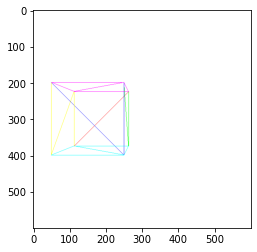

In [18]:
camera = Camera(camera_position = [0,0,0], viewport_size = 1, projection_plane_z = 1)
canvas = Canvas(width=600, height=600)

renderer = Renderer(camera=camera, canvas=canvas)

vertices = []
vertices.append(Vertex(1,1,1))
vertices.append(Vertex(-1,1,1))
vertices.append(Vertex(-1,-1,1))
vertices.append(Vertex(1,-1,1))
vertices.append(Vertex(1,1,-1))
vertices.append(Vertex(-1,1,-1))
vertices.append(Vertex(-1,-1,-1))
vertices.append(Vertex(1,-1,-1))

triangles = []
triangles.append(Triangle(0,1,2,(255,0,0)))
triangles.append(Triangle(0,2,3,(255,0,0)))
triangles.append(Triangle(4,0,3,(0,255,0)))
triangles.append(Triangle(4,3,7,(0,255,0)))
triangles.append(Triangle(5,4,7,(0,0,255)))
triangles.append(Triangle(5,7,6,(0,0,255)))
triangles.append(Triangle(1,5,6,(255,255,0)))
triangles.append(Triangle(1,6,2,(255,255,0)))
triangles.append(Triangle(4,5,1,(255,0,255)))
triangles.append(Triangle(4,1,0,(255,0,255)))
triangles.append(Triangle(2,6,7,(0,255,255)))
triangles.append(Triangle(2,7,3,(0,255,255)))

renderer.render_object(vertices, triangles)
renderer.render()

In [41]:
camera = Camera(camera_position = [0,0,0], viewport_size = 1, projection_plane_z = 1)
canvas = Canvas(width=600, height=600)

renderer = Renderer(camera=camera, canvas=canvas)

vAf = Vertex(-2, -0.5, 5)
vBf = Vertex(-2, 0.5, 5)
vCf = Vertex(-1, 0.5, 5)
vDf = Vertex(-1, -0.5, 5)

vAb = Vertex(-2, -0.5, 6)
vBb = Vertex(-2, 0.5, 6)
vCb = Vertex(-1, 0.5, 6)
vDb = Vertex(-1, -0.5, 6)

# The front face
renderer.draw_line(renderer.project_vertex(vAf),
                   renderer.project_vertex(vBf),
                   color=(0,0,255))
renderer.draw_line(renderer.project_vertex(vBf),
                   renderer.project_vertex(vCf),
                   color=(0,0,255))
renderer.draw_line(renderer.project_vertex(vCf),
                   renderer.project_vertex(vDf),
                   color=(0,0,255))
renderer.draw_line(renderer.project_vertex(vDf),
                   renderer.project_vertex(vAf),
                   color=(0,0,255))

# The back face
renderer.draw_line(renderer.project_vertex(vAb),
                   renderer.project_vertex(vBb),
                   color=(255,0,0))
renderer.draw_line(renderer.project_vertex(vBb),
                   renderer.project_vertex(vCb),
                   color=(255,0,0))
renderer.draw_line(renderer.project_vertex(vCb),
                   renderer.project_vertex(vDb),
                   color=(255,0,0))
renderer.draw_line(renderer.project_vertex(vDb),
                   renderer.project_vertex(vAb),
                   color=(255,0,0))

# The front-to-back edges
renderer.draw_line(renderer.project_vertex(vAf),
                   renderer.project_vertex(vAb),
                   color=(0,255,0))
renderer.draw_line(renderer.project_vertex(vBf),
                   renderer.project_vertex(vBb),
                   color=(0,255,0))
renderer.draw_line(renderer.project_vertex(vCf),
                   renderer.project_vertex(vCb),
                   color=(0,255,0))
renderer.draw_line(renderer.project_vertex(vDf),
                   renderer.project_vertex(vDb),
                   color=(0,255,0))

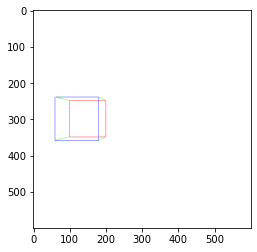

In [42]:
renderer.render()